In [1]:
import json
import shutil
import os
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import Row

In [2]:
# Initialisation de la session Spark avec les packages nécessaires
spark = SparkSession.builder \
    .appName("ProteinGraphWithRDD") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
    .getOrCreate()

# Vérification de l'environnement Spark
print(f"Version de Spark : {spark.version}")

Version de Spark : 3.5.0


In [3]:
file_path = "data/raw/test.tsv" 

In [4]:
# Chargement des données brutes en tant que RDD
raw_rdd = spark.sparkContext.textFile(file_path)

In [5]:
# Extraction de l'en-tête
header = raw_rdd.first()
columns = header.split("\t")
print(f"Header: {columns}")

Header: ['Entry', 'Entry Name', 'Protein names', 'Gene Names', 'Organism', 'Sequence', 'EC number', 'InterPro']


In [6]:
# Suppression de l'en-tête et transformation en lignes tabulées
data_rdd = raw_rdd.filter(lambda line: line != header) \
                  .map(lambda line: line.split("\t"))

In [7]:
# ## Étape 3 : Aperçu des données
# Affichage du nombre total de lignes
print(f"Total rows: {data_rdd.count()}")

Total rows: 61123


In [8]:
# Affichage de quelques lignes
print("Preview of raw data:")
for row in data_rdd.take(1):
    print(row)

Preview of raw data:
['A0A075F5C6', 'A0A075F5C6_MOUSE', 'Heat shock factor 1 (Heat shock transcription factor 1 gammabeta isoform)', 'Hsf1', 'Mus musculus (Mouse)', 'MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHVFDQGQFAKEVLPKYFKHNNMASFVRQLNMYGFRKVVHIEQGGLVKPERDDTEFQHPCFLRGQEQLLENIKRKVTSVSTLKSEDIKIRQDSVTRLLTDVQLMKGKQECMDSKLLAMKHENEALWREVASLRQKHAQQQKVVNKLIQFLISLVQSNRILGVKRKIPLMLSDSNSAHSVPKYGRQYSLEHVHGPGPYSAPSPAYSSSSLYSSDAVTSSGPIISDITELAPTSPLASPGRSIDERPLSSSTLVRVKQEPPSPPHSPRVLEASPGRPSSMDTPLSPTAFIDSILRESEPTPAASNTAPMDTTGAQAPALPTPSTPEKCLSVACLDNLARAPQMSGVARLFPCPSSFLHGRVQPGNELSDHLDAMDSNLDNLQTMLTSHGFSVDTSALLDIQELLSPQEPPRPIEAENSNPDSGKQLVHYTAQPLFLLDPDAVDTGSSELPVLFELGESSYFSEGDDYTDDPTISLLTGTEPHKAKDPTVS', '', 'IPR000232;IPR027725;IPR010542;IPR036388;IPR036390;']


In [9]:
# ## Étape 4 : Conversion en tuples structurés
# Cette étape permet de structurer chaque ligne pour un accès facile aux colonnes
def parse_row(row):
    try:
        return {
            "Entry": row[0],
            "Entry Name": row[1],
            "Protein names": row[2],
            "Gene Names": row[3],
            "Organism": row[4],
            "Sequence": row[5],
            "EC number": row[6] if len(row) > 6 else None,
            "InterPro": row[7].split(";") if len(row) > 7 and row[7] else []
        }
    except IndexError:
        return None

In [10]:
# Transformation des lignes en tuples
structured_rdd = data_rdd.map(parse_row).filter(lambda x: x is not None)

In [11]:
# ## Étape 5 : Vérification du schéma des données
# Aperçu des données structurées
print("Preview of structured data:")
for row in structured_rdd.take(1):
    print(row)

Preview of structured data:
{'Entry': 'A0A075F5C6', 'Entry Name': 'A0A075F5C6_MOUSE', 'Protein names': 'Heat shock factor 1 (Heat shock transcription factor 1 gammabeta isoform)', 'Gene Names': 'Hsf1', 'Organism': 'Mus musculus (Mouse)', 'Sequence': 'MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHVFDQGQFAKEVLPKYFKHNNMASFVRQLNMYGFRKVVHIEQGGLVKPERDDTEFQHPCFLRGQEQLLENIKRKVTSVSTLKSEDIKIRQDSVTRLLTDVQLMKGKQECMDSKLLAMKHENEALWREVASLRQKHAQQQKVVNKLIQFLISLVQSNRILGVKRKIPLMLSDSNSAHSVPKYGRQYSLEHVHGPGPYSAPSPAYSSSSLYSSDAVTSSGPIISDITELAPTSPLASPGRSIDERPLSSSTLVRVKQEPPSPPHSPRVLEASPGRPSSMDTPLSPTAFIDSILRESEPTPAASNTAPMDTTGAQAPALPTPSTPEKCLSVACLDNLARAPQMSGVARLFPCPSSFLHGRVQPGNELSDHLDAMDSNLDNLQTMLTSHGFSVDTSALLDIQELLSPQEPPRPIEAENSNPDSGKQLVHYTAQPLFLLDPDAVDTGSSELPVLFELGESSYFSEGDDYTDDPTISLLTGTEPHKAKDPTVS', 'EC number': '', 'InterPro': ['IPR000232', 'IPR027725', 'IPR010542', 'IPR036388', 'IPR036390', '']}


In [12]:
# ## Étape 2 : Nettoyage et Préparation des Données

# ### Suppression des lignes avec des champs critiques vides
def clean_row(row):
    """
    Nettoie une ligne des données brutes.
    - Vérifie que les champs critiques (Sequence et InterPro) ne sont pas vides.
    - Retourne la ligne nettoyée ou None si invalide.
    """
    if not row["Sequence"] or not row["InterPro"]:
        print(f"Row removed due to missing critical fields: {row}")
        return None
    return row

cleaned_rdd = structured_rdd.map(clean_row).filter(lambda x: x is not None)

In [13]:
# ### Suppression des doublons en utilisant la colonne 'Entry'
cleaned_rdd = cleaned_rdd.map(lambda row: (row["Entry"], row)) \
                         .reduceByKey(lambda a, b: a) \
                         .map(lambda x: x[1])

print("Total rows after cleaning and deduplication:", cleaned_rdd.count())

Total rows after cleaning and deduplication: 55838


In [14]:
# ### Validation des données

def validate_sequence(sequence):
    """
    Vérifie que la séquence contient uniquement des caractères valides pour les acides aminés.
    """
    valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
    invalid_chars = set(sequence) - valid_amino_acids
    if invalid_chars:
        print(f"Invalid characters in sequence: {invalid_chars}")
        return False
    return True

def validate_interpro(interpro_domains):
    """
    Vérifie que chaque domaine InterPro respecte le format 'IPRXXXXX'.
    """
    valid_domains = [domain for domain in interpro_domains if domain.startswith("IPR") and domain[3:].isdigit()]
    if len(valid_domains) < len(interpro_domains):
        print(f"Some invalid domains were removed: {set(interpro_domains) - set(valid_domains)}")
    return valid_domains

def validate_row(row):
    """
    Valide une ligne pour vérifier que :
    - La séquence contient uniquement des caractères valides.
    - Les domaines InterPro sont bien formatés.
    """
    # Validation de la séquence
    if not validate_sequence(row["Sequence"]):
        print(f"Row removed due to invalid sequence: {row}")
        return None

    # Validation des domaines InterPro
    row["InterPro"] = validate_interpro(row["InterPro"])
    if not row["InterPro"]:
        print(f"Row removed due to all invalid InterPro domains: {row}")
        return None

    return row

validated_rdd = cleaned_rdd.map(validate_row).filter(lambda x: x is not None)
print("Total validated rows:", validated_rdd.count())

Total validated rows: 53845


In [15]:
# ### Normalisation des domaines InterPro
def normalize_interpro(row):
    """
    Normalise la colonne InterPro en la transformant en un ensemble unique.
    """
    row["InterPro"] = list(set(row["InterPro"]))
    return row

normalized_rdd = validated_rdd.map(normalize_interpro)
print("Total rows after normalization:", normalized_rdd.count())

Total rows after normalization: 53845


In [16]:
print("Preview of structured data:")
for row in normalized_rdd.take(1):
    print(row)

Preview of structured data:
{'Entry': 'A0A075F5C6', 'Entry Name': 'A0A075F5C6_MOUSE', 'Protein names': 'Heat shock factor 1 (Heat shock transcription factor 1 gammabeta isoform)', 'Gene Names': 'Hsf1', 'Organism': 'Mus musculus (Mouse)', 'Sequence': 'MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHVFDQGQFAKEVLPKYFKHNNMASFVRQLNMYGFRKVVHIEQGGLVKPERDDTEFQHPCFLRGQEQLLENIKRKVTSVSTLKSEDIKIRQDSVTRLLTDVQLMKGKQECMDSKLLAMKHENEALWREVASLRQKHAQQQKVVNKLIQFLISLVQSNRILGVKRKIPLMLSDSNSAHSVPKYGRQYSLEHVHGPGPYSAPSPAYSSSSLYSSDAVTSSGPIISDITELAPTSPLASPGRSIDERPLSSSTLVRVKQEPPSPPHSPRVLEASPGRPSSMDTPLSPTAFIDSILRESEPTPAASNTAPMDTTGAQAPALPTPSTPEKCLSVACLDNLARAPQMSGVARLFPCPSSFLHGRVQPGNELSDHLDAMDSNLDNLQTMLTSHGFSVDTSALLDIQELLSPQEPPRPIEAENSNPDSGKQLVHYTAQPLFLLDPDAVDTGSSELPVLFELGESSYFSEGDDYTDDPTISLLTGTEPHKAKDPTVS', 'EC number': '', 'InterPro': ['IPR036390', 'IPR027725', 'IPR000232', 'IPR010542', 'IPR036388']}


In [17]:
# ### Filtrage par longueur de séquence
def filter_sequence_length(row, min_length=1, max_length=10000):
    """
    Filtre les protéines en fonction de la longueur de leur séquence.
    """
    sequence_length = len(row["Sequence"])
    if min_length <= sequence_length <= max_length:
        return row
    print(f"Row removed due to sequence length ({sequence_length}): {row}")
    return None

filtered_rdd = normalized_rdd.map(lambda row: filter_sequence_length(row)).filter(lambda x: x is not None)
print("Total rows after filtering by sequence length:", filtered_rdd.count())

Total rows after filtering by sequence length: 53841


In [18]:
print("Preview of filtering  data:")
for row in filtered_rdd.take(6):
    print(row)

Preview of filtering  data:
{'Entry': 'A0A075F5C6', 'Entry Name': 'A0A075F5C6_MOUSE', 'Protein names': 'Heat shock factor 1 (Heat shock transcription factor 1 gammabeta isoform)', 'Gene Names': 'Hsf1', 'Organism': 'Mus musculus (Mouse)', 'Sequence': 'MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHVFDQGQFAKEVLPKYFKHNNMASFVRQLNMYGFRKVVHIEQGGLVKPERDDTEFQHPCFLRGQEQLLENIKRKVTSVSTLKSEDIKIRQDSVTRLLTDVQLMKGKQECMDSKLLAMKHENEALWREVASLRQKHAQQQKVVNKLIQFLISLVQSNRILGVKRKIPLMLSDSNSAHSVPKYGRQYSLEHVHGPGPYSAPSPAYSSSSLYSSDAVTSSGPIISDITELAPTSPLASPGRSIDERPLSSSTLVRVKQEPPSPPHSPRVLEASPGRPSSMDTPLSPTAFIDSILRESEPTPAASNTAPMDTTGAQAPALPTPSTPEKCLSVACLDNLARAPQMSGVARLFPCPSSFLHGRVQPGNELSDHLDAMDSNLDNLQTMLTSHGFSVDTSALLDIQELLSPQEPPRPIEAENSNPDSGKQLVHYTAQPLFLLDPDAVDTGSSELPVLFELGESSYFSEGDDYTDDPTISLLTGTEPHKAKDPTVS', 'EC number': '', 'InterPro': ['IPR036390', 'IPR027725', 'IPR000232', 'IPR010542', 'IPR036388']}
{'Entry': 'A0A087WPF7', 'Entry Name': 'AUTS2_MOUSE', 'Protein names': 'Autism susceptibility gene 2 protein homolog', '

In [19]:
# ### Ajout d'une colonne de classification
def classify_protein(row):
    """
    Classe les protéines comme 'Known' ou 'Unknown' en fonction de la colonne EC number.
    """
    row["Status"] = "Known" if row["EC number"] else "Unknown"
    return row

classified_rdd = filtered_rdd.map(classify_protein)
print("Total rows after classification:", classified_rdd.count())

Total rows after classification: 53841


In [20]:
# ### Statistiques supplémentaires
# Distribution des séquences par longueur
sequence_lengths = classified_rdd.map(lambda row: len(row["Sequence"]))
if sequence_lengths.isEmpty():
    print("No sequences available for statistics.")
else:
    length_stats = sequence_lengths.stats()
    print(f"Sequence length statistics: {length_stats}")

Sequence length statistics: (count: 53841, mean: 483.76129715272714, stdev: 496.9542603693239, max: 8886.0, min: 11.0)


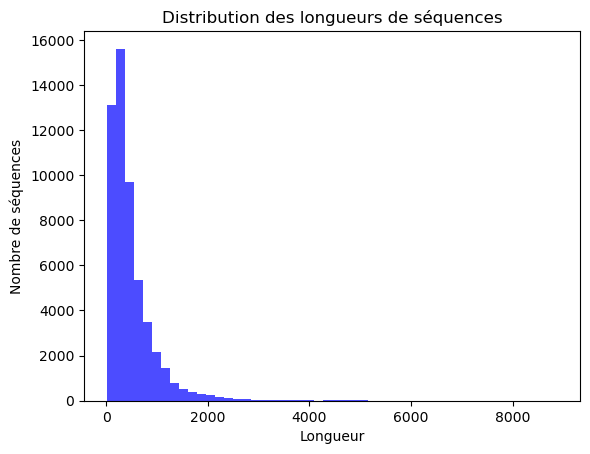

In [21]:
lengths = classified_rdd.map(lambda row: len(row["Sequence"])).collect()
plt.hist(lengths, bins=50, color='blue', alpha=0.7)
plt.title("Distribution des longueurs de séquences")
plt.xlabel("Longueur")
plt.ylabel("Nombre de séquences")
plt.show()

In [22]:
# Comptage des protéines par organisme
proteins_per_organism = classified_rdd.map(lambda row: (row["Organism"], 1)) \
                                     .reduceByKey(lambda a, b: a + b) \
                                     .collect()
if not proteins_per_organism:
    print("No proteins available for organism statistics.")
else:
    print("Proteins per organism:")
    for organism, count in proteins_per_organism:
        print(f"{organism}: {count}")

Proteins per organism:
Mus musculus (Mouse): 53841


In [23]:
# ### Échantillonnage des données
sampled_rdd = classified_rdd.sample(False, 0.05, seed=42)
print(f"Sample size: {sampled_rdd.count()}")

print("data preview:")
for row in sampled_rdd.take(5):
    print(row)

Sample size: 2636
data preview:
{'Entry': 'A0A075F5C6', 'Entry Name': 'A0A075F5C6_MOUSE', 'Protein names': 'Heat shock factor 1 (Heat shock transcription factor 1 gammabeta isoform)', 'Gene Names': 'Hsf1', 'Organism': 'Mus musculus (Mouse)', 'Sequence': 'MDLAVGPGAAGPSNVPAFLTKLWTLVSDPDTDALICWSPSGNSFHVFDQGQFAKEVLPKYFKHNNMASFVRQLNMYGFRKVVHIEQGGLVKPERDDTEFQHPCFLRGQEQLLENIKRKVTSVSTLKSEDIKIRQDSVTRLLTDVQLMKGKQECMDSKLLAMKHENEALWREVASLRQKHAQQQKVVNKLIQFLISLVQSNRILGVKRKIPLMLSDSNSAHSVPKYGRQYSLEHVHGPGPYSAPSPAYSSSSLYSSDAVTSSGPIISDITELAPTSPLASPGRSIDERPLSSSTLVRVKQEPPSPPHSPRVLEASPGRPSSMDTPLSPTAFIDSILRESEPTPAASNTAPMDTTGAQAPALPTPSTPEKCLSVACLDNLARAPQMSGVARLFPCPSSFLHGRVQPGNELSDHLDAMDSNLDNLQTMLTSHGFSVDTSALLDIQELLSPQEPPRPIEAENSNPDSGKQLVHYTAQPLFLLDPDAVDTGSSELPVLFELGESSYFSEGDDYTDDPTISLLTGTEPHKAKDPTVS', 'EC number': '', 'InterPro': ['IPR036390', 'IPR027725', 'IPR000232', 'IPR010542', 'IPR036388'], 'Status': 'Unknown'}
{'Entry': 'A0A0A6YXR0', 'Entry Name': 'A0A0A6YXR0_MOUSE', 'Protein names': 'Choline/ethanolami

In [24]:
# ## Étape 3 : Construction des Nœuds

# ### Création des Nœuds
def create_node(row):
    """
    Transforme une ligne en un nœud avec ses attributs.
    """
    try:
        return {
            "id": row["Entry"],  
            "name": row.get("Protein names", ""),
            "gene": row.get("Gene Names", ""),
            "organism": row.get("Organism", ""),
            "domains": row.get("InterPro", []),
            "status": row.get("Status", "Unknown")
        }
    except KeyError as e:
        print(f"KeyError in create_node: {e}")
        return None

nodes_rdd = classified_rdd.map(create_node).filter(lambda x: x is not None)

# Fonction pour gérer la suppression des fichiers existants
def safe_save_as_textfile(rdd, path):
    """
    Sauvegarde un RDD dans un dossier tout en écrasant les fichiers existants.
    """
    if os.path.exists(path):
        print(f"Le chemin {path} existe. Suppression en cours...")
        shutil.rmtree(path)
    rdd.map(lambda x: json.dumps(x)).saveAsTextFile(path)
    print(f"Fichiers sauvegardés dans : {path}")

# Exportation des nœuds en JSON
output_nodes_path = "path/to/nodes.json"  # Remplacez par votre chemin
safe_save_as_textfile(nodes_rdd, output_nodes_path)

# Aperçu des nœuds créés
print("Sample nodes:")
for node in nodes_rdd.take(5):
    print(node)

Fichiers sauvegardés dans : path/to/nodes.json
Sample nodes:
{'id': 'A0A075F5C6', 'name': 'Heat shock factor 1 (Heat shock transcription factor 1 gammabeta isoform)', 'gene': 'Hsf1', 'organism': 'Mus musculus (Mouse)', 'domains': ['IPR036390', 'IPR027725', 'IPR000232', 'IPR010542', 'IPR036388'], 'status': 'Unknown'}
{'id': 'A0A087WPF7', 'name': 'Autism susceptibility gene 2 protein homolog', 'gene': 'Auts2 Kiaa0442', 'organism': 'Mus musculus (Mouse)', 'domains': ['IPR023246'], 'status': 'Unknown'}
{'id': 'A0A087WRT4', 'name': 'FAT atypical cadherin 1', 'gene': 'Fat1', 'organism': 'Mus musculus (Mouse)', 'domains': ['IPR018097', 'IPR000742', 'IPR002126', 'IPR001791', 'IPR009030', 'IPR020894', 'IPR039808', 'IPR001881', 'IPR000152', 'IPR015919', 'IPR013320', 'IPR049883'], 'status': 'Unknown'}
{'id': 'A0A0A6YXR0', 'name': 'Choline/ethanolaminephosphotransferase 1 (EC 2.7.8.1) (EC 2.7.8.2) (EC 2.7.8.22) (1-alkenyl-2-acylglycerol choline phosphotransferase)', 'gene': 'Cept1', 'organism': 'M

In [25]:
# ## la Création des Arêtes

# ### Fonction de Similarité de Jaccard
def jaccard_similarity(domains1, domains2):
    set1, set2 = set(domains1), set(domains2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

# ### Filtrage basé sur la taille des domaines
def should_compare(node1, node2):
    """
    Vérifie si deux nœuds doivent être comparés en fonction de la taille des domaines.
    """
    len1, len2 = len(node1["domains"]), len(node2["domains"])
    return abs(len1 - len2) <= 5  # Tolérance sur la taille des domaines

# ### Création des partitions par organisme et hashing pour optimiser les comparaisons
def hash_domains(domains):
    """
    Génère un hash simplifié basé sur les domaines pour limiter les comparaisons.
    """
    return hash(tuple(sorted(domains))) % 100  # Exemple : 100 partitions logiques

def create_partitioned_edges(node, partitioned_data):
    """
    Génère les arêtes pour un nœud donné en comparant uniquement avec les nœuds de la même partition.
    """
    source = node["id"]
    source_domains = node["domains"]
    source_hash = hash_domains(source_domains)
    edges = []
    for target_node in partitioned_data.get(source_hash, []):
        target = target_node["id"]
        target_domains = target_node["domains"]
        if should_compare(node, target_node):
            similarity = jaccard_similarity(source_domains, target_domains)
            if similarity > 0.3:  # Seuil de similarité
                edges.append({"source": source, "target": target, "weight": similarity})
    return edges

# Ajout d'un hash logique aux partitions
nodes_with_hashes = nodes_rdd.map(lambda node: {**node, "hash": hash_domains(node["domains"])})
partitioned_data = nodes_with_hashes.groupBy(lambda node: node["hash"]).mapValues(list).collectAsMap()
partitioned_data_broadcast = spark.sparkContext.broadcast(partitioned_data)

# Création des arêtes optimisées
edges_rdd = nodes_with_hashes.flatMap(lambda node: create_partitioned_edges(node, partitioned_data_broadcast.value))

# ### Exportation des Arêtes
output_edges_path = "path/to/edges.json"  # Remplacez par votre chemin
edges_rdd.map(lambda edge: json.dumps(edge)).saveAsTextFile(output_edges_path)

# Aperçu des Arêtes Créées
print("Sample edges:")
for edge in edges_rdd.take(5):
    print(edge)

# ### Résumé des Résultats
print(f"Total nodes: {nodes_rdd.count()}")
print(f"Total edges: {edges_rdd.count()}")

# ### Fonction de Similarité de Jaccard
def jaccard_similarity(domains1, domains2):
    set1, set2 = set(domains1), set(domains2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0

# ### Filtrage basé sur la taille des domaines
def should_compare(node1, node2):
    """
    Vérifie si deux nœuds doivent être comparés en fonction de la taille des domaines.
    """
    len1, len2 = len(node1["domains"]), len(node2["domains"])
    return abs(len1 - len2) <= 5  # Tolérance sur la taille des domaines

# ### Création des partitions par organisme et hashing pour optimiser les comparaisons
def hash_domains(domains):
    """
    Génère un hash simplifié basé sur les domaines pour limiter les comparaisons.
    """
    return hash(tuple(sorted(domains))) % 100  # Exemple : 100 partitions logiques

def create_partitioned_edges(node, partitioned_data):
    """
    Génère les arêtes pour un nœud donné en comparant uniquement avec les nœuds de la même partition.
    """
    source = node["id"]
    source_domains = node["domains"]
    source_hash = hash_domains(source_domains)
    edges = []
    for target_node in partitioned_data.get(source_hash, []):
        target = target_node["id"]
        target_domains = target_node["domains"]
        if should_compare(node, target_node):
            similarity = jaccard_similarity(source_domains, target_domains)
            if similarity > 0.5:  
                edges.append({"source": source, "target": target, "weight": similarity})
    return edges

# Ajout d'un hash logique aux partitions
nodes_with_hashes = nodes_rdd.map(lambda node: {**node, "hash": hash_domains(node["domains"])})
partitioned_data = nodes_with_hashes.groupBy(lambda node: node["hash"]).mapValues(list).collectAsMap()
partitioned_data_broadcast = spark.sparkContext.broadcast(partitioned_data)

# Création des arêtes optimisées
edges_rdd = nodes_with_hashes.flatMap(lambda node: create_partitioned_edges(node, partitioned_data_broadcast.value))

# Fonction pour supprimer un répertoire s'il existe
def safe_save_edges_as_textfile(rdd, path):
    """
    Sauvegarde un RDD dans un fichier texte tout en supprimant les fichiers existants.
    """
    if os.path.exists(path):
        print(f"Le chemin {path} existe. Suppression en cours...")
        shutil.rmtree(path)
    rdd.map(lambda x: json.dumps(x)).saveAsTextFile(path)
    print(f"Fichiers sauvegardés dans : {path}")

# Exportation des arêtes
output_edges_path = "path/to/edges.json" 
safe_save_edges_as_textfile(edges_rdd, output_edges_path)

# Aperçu des Arêtes Créées
print("Edges:")
for edge in edges_rdd.take(5):
    print(edge)

Sample edges:
{'source': 'A0A075F5C6', 'target': 'A0A075F5C6', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'P38532', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'P38533', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'Q8BWK6', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'A0A075F6C2', 'weight': 1.0}
Total nodes: 53841
Total edges: 2054347
Le chemin path/to/edges.json existe. Suppression en cours...
Fichiers sauvegardés dans : path/to/edges.json
Sample edges:
{'source': 'A0A075F5C6', 'target': 'A0A075F5C6', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'P38532', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'P38533', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'Q8BWK6', 'weight': 1.0}
{'source': 'A0A075F5C6', 'target': 'A0A075F6C2', 'weight': 1.0}


In [26]:
# ### Résumé des Résultats
print(f"Total nodes: {nodes_rdd.count()}")
print(f"Total edges: {edges_rdd.count()}")

Total nodes: 53841
Total edges: 1982121


In [27]:
# Calcul du degré des nœuds (nombre d'arêtes associées)
node_degrees = edges_rdd.map(lambda edge: (edge["source"], 1)).reduceByKey(lambda a, b: a + b)
print("Top nodes by degree:")
for node, degree in node_degrees.takeOrdered(10, key=lambda x: -x[1]):
    print(f"Node {node} has degree {degree}")

Top nodes by degree:
Node Q8VEY3 has degree 1023
Node Q8VEZ0 has degree 1023
Node Q8VFK2 has degree 1023
Node Q8VFX2 has degree 1023
Node A2BHP6 has degree 1023
Node P34983 has degree 1023
Node P34984 has degree 1023
Node P34985 has degree 1023
Node Q0VAX9 has degree 1023
Node Q60880 has degree 1023


In [28]:
from graphframes import GraphFrame
from pyspark.sql import SparkSession

# Convertir les RDDs en DataFrames
nodes_df = nodes_rdd.map(lambda node: (node["id"], node)).toDF(["id", "attributes"])
edges_df = edges_rdd.map(lambda edge: (edge["source"], edge["target"], edge["weight"])).toDF(["src", "dst", "weight"])

# Construire le graphe
graph = GraphFrame(nodes_df, edges_df)

# Analyse basique
graph.vertices.show()  # Affiche les nœuds
graph.edges.show()     # Affiche les arêtes


/usr/local/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+----------+--------------------+
|        id|          attributes|
+----------+--------------------+
|A0A075F5C6|{organism -> Mus ...|
|A0A087WPF7|{organism -> Mus ...|
|A0A087WRT4|{organism -> Mus ...|
|A0A0A6YXR0|{organism -> Mus ...|
|A0A0A6YXU9|{organism -> Mus ...|
|A0A0B4J1G0|{organism -> Mus ...|
|A0A0B4J1N3|{organism -> Mus ...|
|A0A0G2JGI9|{organism -> Mus ...|
|A0A0R4IZW5|{organism -> Mus ...|
|A0A0R4IZY3|{organism -> Mus ...|
|A0A0R4J049|{organism -> Mus ...|
|A0A0R4J093|{organism -> Mus ...|
|A0A0R4J0N8|{organism -> Mus ...|
|A0A0R4J115|{organism -> Mus ...|
|A0A0R4J136|{organism -> Mus ...|
|A0A0R4J1M7|{organism -> Mus ...|
|A0A0R4J1Q7|{organism -> Mus ...|
|A0A0U1RNJ1|{organism -> Mus ...|
|A0A0U1RNR0|{organism -> Mus ...|
|A0A0U1RPR8|{organism -> Mus ...|
+----------+--------------------+
only showing top 20 rows

+----------+----------+------+
|       src|       dst|weight|
+----------+----------+------+
|A0A075F5C6|A0A075F5C6|   1.0|
|A0A075F5C6|    P38532|   1.0|
|A0